In [26]:
import os, json
import pandas as pd
import timeit
import sqlalchemy as alch
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
plt.rcParams.update({'font.size': 22})

In [2]:
# convert the dataframe to sql and write out to a file
engine = alch.create_engine('sqlite:///jobs.db', echo=False)

In [3]:
%%time
with engine.connect() as connection:
    result = connection.execute("select count(*) from \"main\".\"jobs.db\" ")
    number_of_rows = result.first()[0]
print(number_of_rows)

3299995
Wall time: 1.24 s


In [4]:
dates_posted = np.array([None]*number_of_rows)
expiry_dates = np.array([None]*number_of_rows)

In [5]:
%%time
with engine.connect() as connection:
    result = connection.execute("select datePosted from \"main\".\"jobs.db\"")
    i = 0
    nones = 0
    for row in result:
        try:
            dates_posted[i] = datetime.strptime(row[0],"%d/%m/%Y")
        except:
            dates_posted[i] = None
            nones+=1
        i+=1  
        if i % 100000 == 0:
            print(i,"rows processed")

100000 rows processed
200000 rows processed
300000 rows processed
400000 rows processed
500000 rows processed
600000 rows processed
700000 rows processed
800000 rows processed
900000 rows processed
1000000 rows processed
1100000 rows processed
1200000 rows processed
1300000 rows processed
1400000 rows processed
1500000 rows processed
1600000 rows processed
1700000 rows processed
1800000 rows processed
1900000 rows processed
2000000 rows processed
2100000 rows processed
2200000 rows processed
2300000 rows processed
2400000 rows processed
2500000 rows processed
2600000 rows processed
2700000 rows processed
2800000 rows processed
2900000 rows processed
3000000 rows processed
3100000 rows processed
3200000 rows processed
Wall time: 1min 11s


In [6]:
dates_posted_filtered = [None]*(number_of_rows-nones)

In [7]:
c=0
for i in range(len(dates_posted)):
    if dates_posted[i] != None:
        dates_posted_filtered[c] = dates_posted[i]
        c+=1

In [8]:
%%time
dates_posted = mdates.date2num(dates_posted_filtered)

Wall time: 7.76 s


In [9]:
%%time
days = Counter(dates_posted).keys() 
posts = Counter(dates_posted).values()

Wall time: 1.1 s


In [35]:
fig = plt.figure(figsize=(20,15))
ax = plt.gca()
fig.autofmt_xdate()
#formatter = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(formatter)
locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(locator)
plt.title("Job adverts posted to Reed per day")
plt.xlabel("Date")
plt.ylabel("Number of jobs posted")

plt.plot(list(days), list(posts))

In [11]:
# We will now redo the calculations with a weekly total instead of a daily value
print(dates_posted[78])

737069.0


In [12]:
print(len(posts))

476


In [13]:
# array to hold the weekly total
weekly_totals = []
# array to hold the daily counts
daily_totals = [0,0,0,0,0,0,0]
# array to hold the datetime objects for each end of week
weeks = []
# find out what weekday the first day is
w=mdates.num2date(dates_posted[0]).weekday()

# initialise the running total
running_total = 0

# for every day, add the daily posts to the running total, if sunday add to the weekly total and then reset the day counter
c = 0
for i in posts: 
    running_total = running_total + i
    daily_totals[w] = daily_totals[w] + i
    c+=1
    if w==6:
        w=0
        weekly_totals.append(running_total)
        weeks.append(list(days)[c])
        running_total = 0
    else:
        w+=1
    

In [14]:
print(len(weekly_totals))
print(daily_totals)
print(len(weeks))
print(list(days)[0])

68
[620136, 658001, 630630, 612080, 657925, 51694, 48706]
68
737069.0


In [15]:
weeks = weeks[1:]
weekly_totals = weekly_totals[1:]

series = pd.Series(weekly_totals)
rolling_window = series.rolling(4)
rolling_average = rolling_window.mean()
weekly_rolling = rolling_average.tolist()
#weekly_rolling[0]= weekly_rolling[3]
#weekly_rolling[1]= weekly_rolling[3]
#weekly_rolling[2]= weekly_rolling[3]

In [36]:
fig = plt.figure(figsize=(20,15))
ax = plt.gca()
fig.autofmt_xdate()
#formatter = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(formatter)
locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(locator)
plt.title("Job adverts posted to Reed per week")
plt.xlabel("Date")
plt.ylabel("Number of jobs posted")
plt.plot(weeks, weekly_totals, label='Weekly total')
plt.plot(weeks, weekly_rolling, label='Rolling average over 4 weeks')
plt.legend(fontsize='xx-large',loc=3)
plt.savefig('jobs_per_week.png', dpi=300)
plt.show()


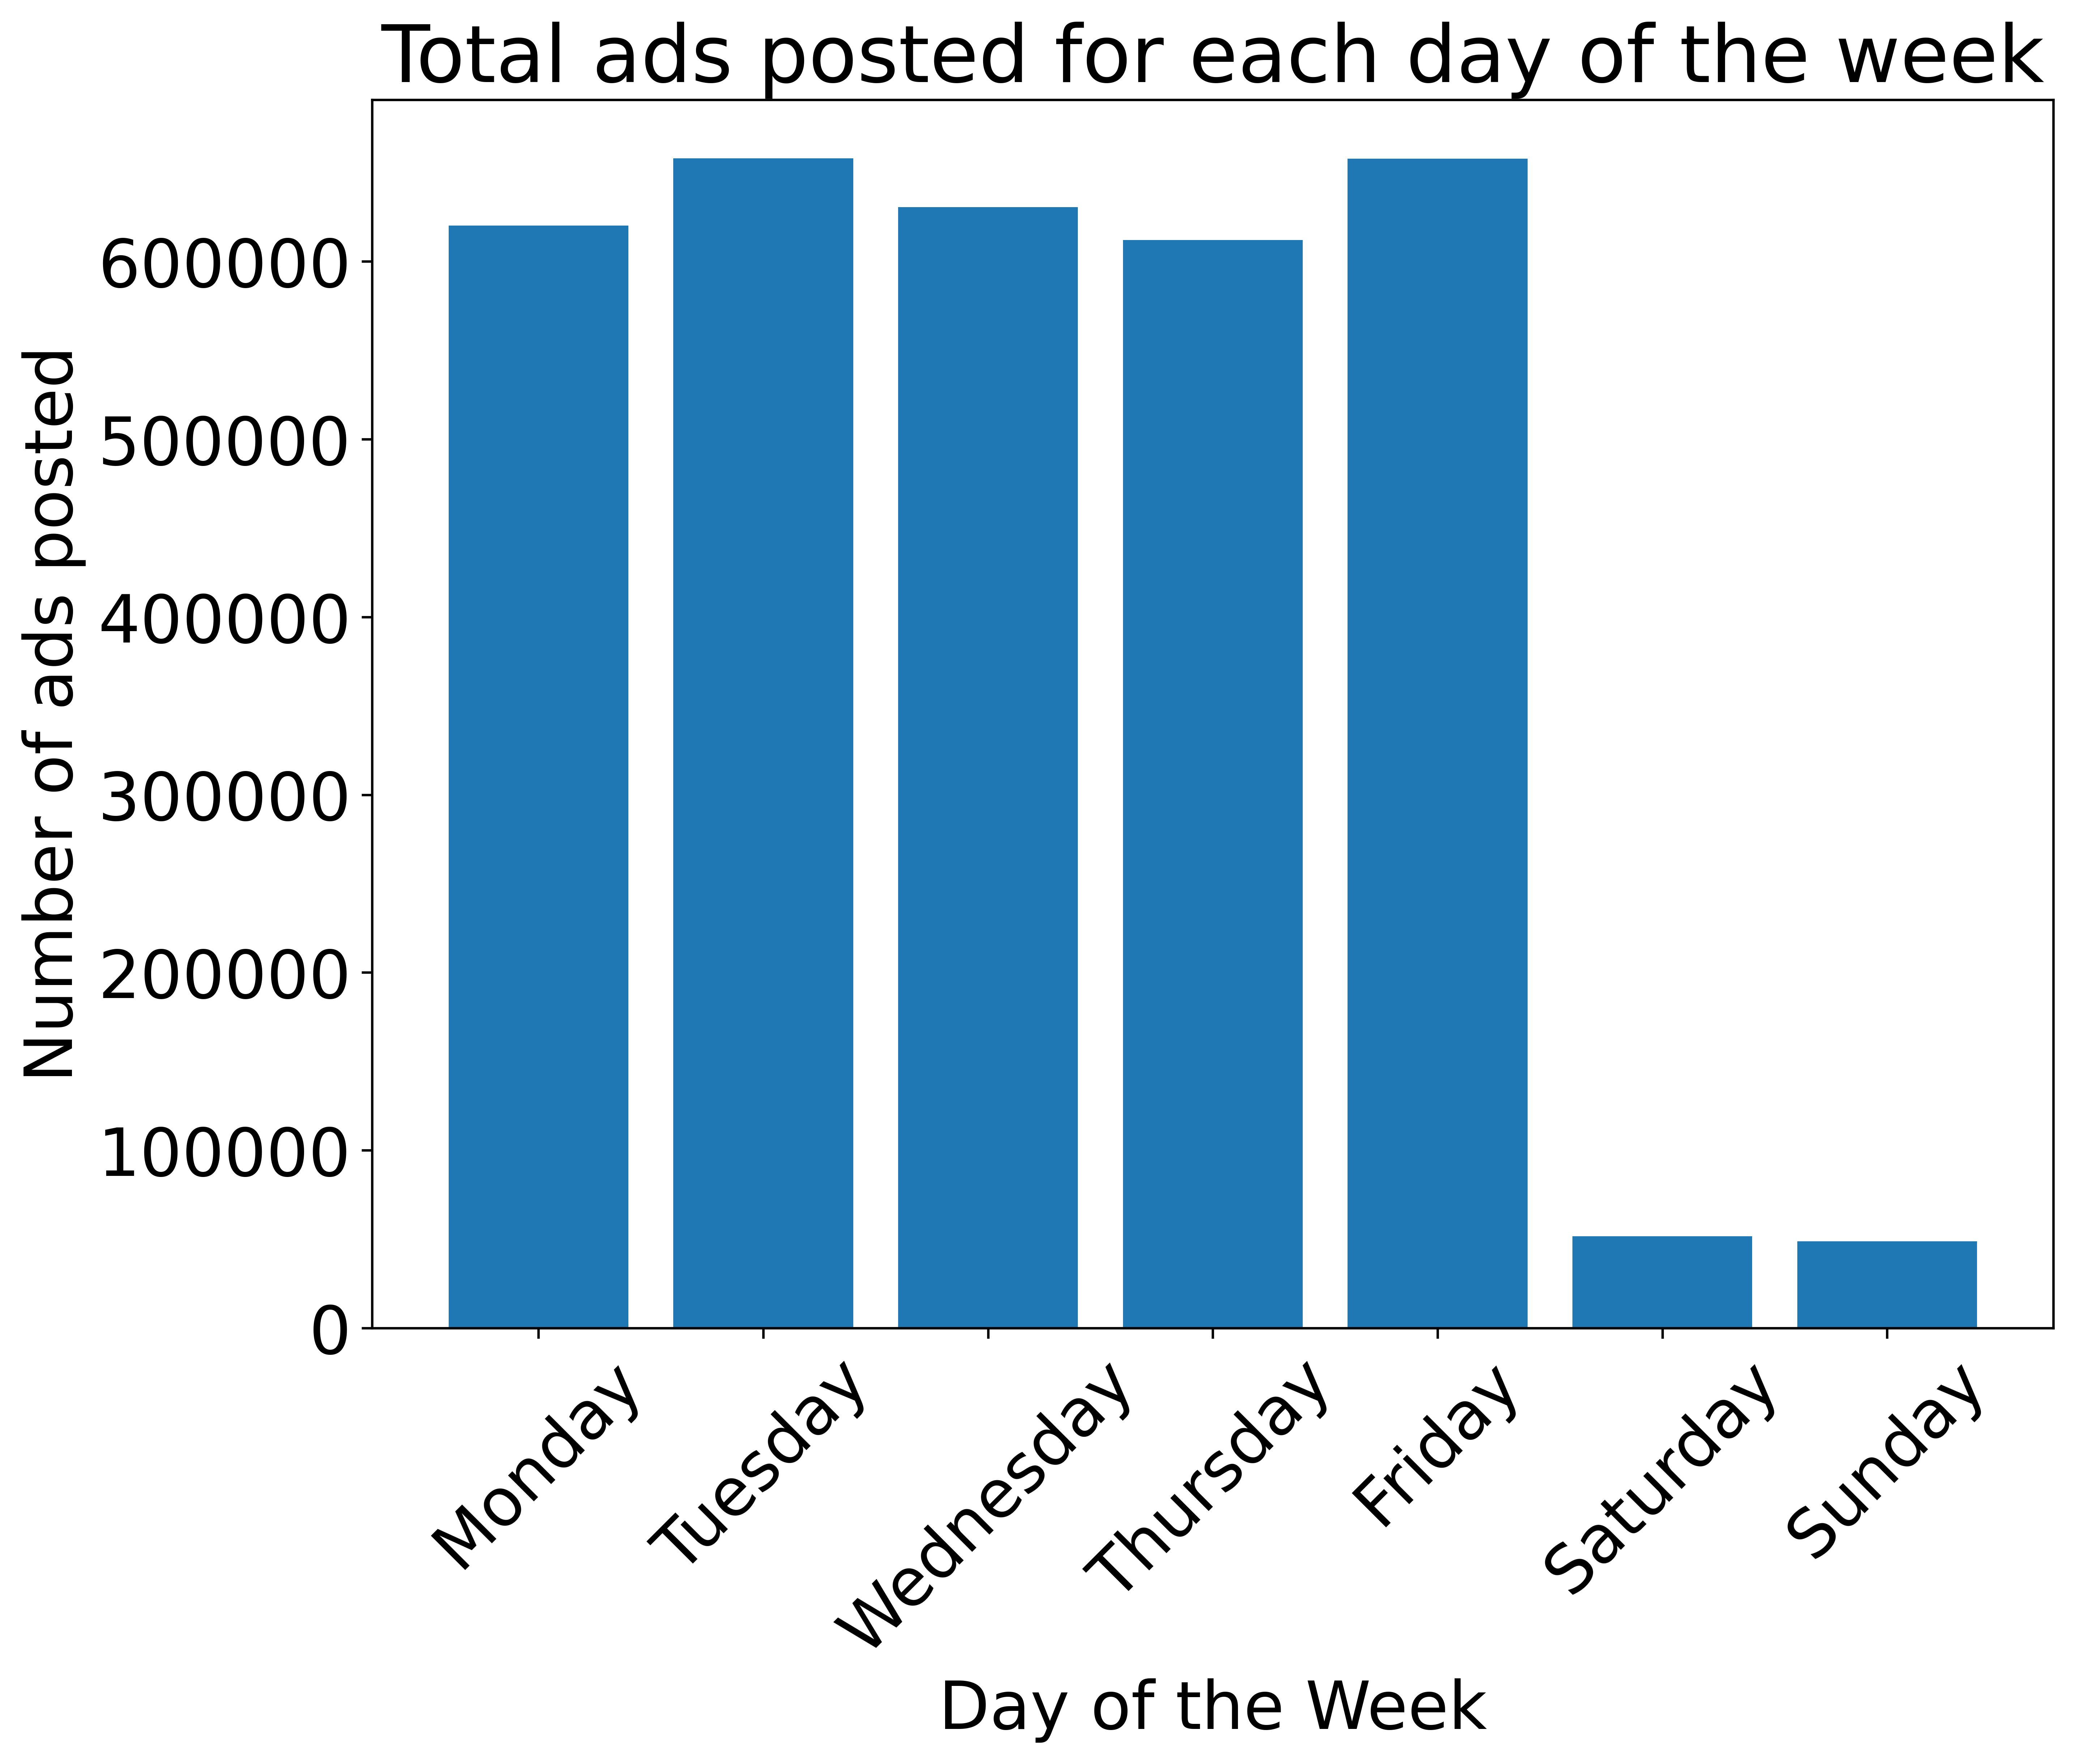

In [39]:
fig = plt.figure(figsize=(10,7.5))
x = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
x_pos = [i for i, _ in enumerate(x)]


plt.bar(x_pos, daily_totals)
plt.xlabel("Day of the Week")
plt.ylabel("Number of ads posted")
plt.title("Total ads posted for each day of the week")

plt.xticks(x_pos, x, rotation=45)

plt.show()